# IMDB Reviews Classification

## Problem Statement

Analyzing the effects of Architecture, Number of neurons, and Batch size on a sentiment analysis problem.

We'll be classifying if the review is positive or negative.

The following is an extract of the article "Python for NLP: Movie Sentiment Analysis using Deep Learning in Keras" (available at: https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/)

## The Dataset
The dataset that can be downloaded from this Kaggle link (https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).

If you download the dataset and extract the compressed file, you will see a CSV file. The file contains 50,000 records and two columns: review and sentiment. The review column contains text for the review and the sentiment column contains sentiment for the review. The sentiment column can have two values i.e. "positive" and "negative" which makes our problem a binary classification problem.

## Importing Required Libraries

In [249]:
# The following script imports the required libraries:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

## Importing and Analyzing the Dataset

In [250]:
# Read csv
movie_reviews = pd.read_csv("IMDB Dataset.csv")

In [251]:
# Check if the dataset contains any NULL value or not
movie_reviews.isnull().values.any()

False

In [252]:
# Shape of dataset
movie_reviews.shape

(50000, 2)

Note: In the script above we use the read_csv() method of the pandas library to read the CSV file containing our dataset. In the next cell, we checked if the dataset contains any NULL value or not. Finally, we print the shape of our dataset.

Let's now print the first 5 rows of the dataset using the head() method.

In [253]:
# Print first 5 rows
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Note: Let's now take a look at any one of the reviews so that we have an idea about the text that we are going to process. Look at the following script.

In [254]:
# Print any review from the dataset
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

Note: You can see that our text contains punctuations, brackets, and a few HTML tags as well. We will preprocess this text in the next section.

Finally, let's see the distribution of positive and negative sentiments in our dataset.

<AxesSubplot: xlabel='sentiment', ylabel='count'>

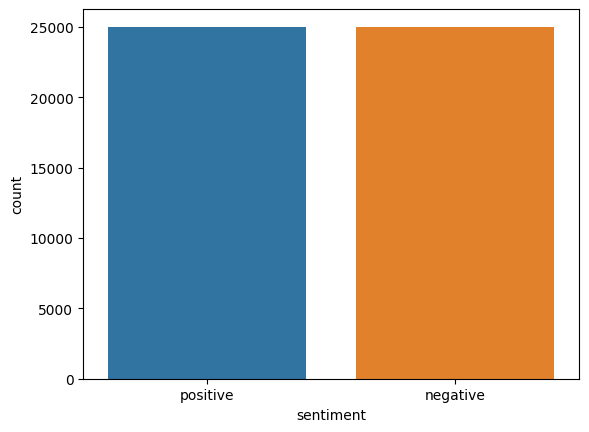

In [255]:
# Check the distribution of positive and negative sentiments in our dataset
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

Note: From the output, it is clear that the dataset contains equal number of positive and negative reviews

## Data Preprocessing

Note: We saw that our dataset contained punctuations and HTML tags. In this section we will define a function that takes a text string as a parameter and then performs preprocessing on the string to remove special characters and HTML tags from the string. Finally, the string is returned to the calling function. Look at the following script:

In [256]:
# Define a function that takes a text string as a parameter and then performs preprocessing on the string 
# to remove special characters and HTML tags from the string
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

Note: In the preprocess_text() method the first step is to remove the HTML tags. To remove the HTML tags, remove_tags() function has been defined. The remove_tags function simply replaces anything between opening and closing <> with an empty space.

Next, in the preprocess_text function, everything is removed except capital and small English letters, which results in single characters that make no sense. For instance, when you remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s".

Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

Next, we will preprocess our reviews and will store them in a new list as shown below:

In [257]:
# Applying the above function to the review column
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

Let's now again see the fourth review:

In [258]:
# Print the same review
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

Note: From the output, you can see that the HTML tags, punctuations and numbers have been removed. We are only left with the alphabets.

Next, we need to convert our labels into digits. Since we only have two labels in the output i.e. "positive" and "negative". We can simply convert them into integers by replacing "positive" with digit 1 and negative with digit 0 as shown below:

In [259]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

## Splitting the dataset into train and test dataset

Finally, we need to divide our dataset into train and test sets. The train set will be used to train our deep learning models while the test set will be used to evaluate how well our model performs.
We can use train_test_split method from the sklearn.model.selection module, as shown below:

In [260]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Note: The script above divides our data into 80% for the training set and 20% for the testing set.

Let's now write the script for our embedding layer. The embedding layer converts our textual data into numeric data and is used as the first layer for the deep learning models in Keras.

## Preparing the Embedding Layer

Note: As a first step, we will use the Tokenizer class from the keras.preprocessing.text module to create a word-to-index dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key. Execute the following script:

In [261]:
#  Creating tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Note: If you view the X_train variable in variable explorer, you will see that it contains 40,000 lists where each list contains integers. Each list actually corresponds to each sentence in the training set. You will also notice that the size of each list is different. This is because sentences have different lengths.

We set the maximum size of each list to 100. You can try a different size. The lists with size greater than 100 will be truncated to 100. For the lists that have length less than 100, we will add 0 at the end of the list until it reaches the max length. This process is called padding.

The following script finds the vocabulary size and then perform padding on both train and test set.

In [262]:
# Find the vocabulary size and then perform padding on both train and test set
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Note: Now if you view the X_train or X_test, you will see that all the lists have same length i.e. 100. Also, the vocabulary_size variable now contains a value 92547 which means that our corpus has 92547 unique words.

We will use GloVe embeddings to create our feature matrix. In the following script we load the GloVe word embeddings and create a dictionary that will contain words as keys and their corresponding embedding list as values.
(glove.6B.100d.txt is available at https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt)

In [263]:
# We will use GloVe embeddings to create our feature matrix
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

Note: Finally, we will create an embedding matrix where each row number will correspond to the index of the word in the corpus. The matrix will have 100 columns where each column will contain the GloVe word embeddings for the words in our corpus.

In [264]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [265]:
# Embedding matrix shape
embedding_matrix.shape

(92547, 100)

Note: Once you execute the above script, you will see that embedding_matrix will contain 92547 rows (one for each word in the corpus). Now we are ready to create our deep learning models.

## We start building our DL Models from here

We will define a set of models all based on the same structure ( Embedding layer -> Recurring layer -> Dense layer -> Dense output layer ). All the hidden layers will utilize a ReLU activation function and will have a kernel initialized with a He normal initialization. The output layer will use a sigmoid function and will be initialized with a Glorot normal initialization.

In [266]:
# Importing the libraries
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Dense, LSTM, GRU
import keras
from numpy.random import seed

seed(42)

In [267]:
# Define a function that creates LSTM and GRU models
def create_model(model_type, layer_size, learning_rate, embedding_layer):
    # Create a sequential model
    model = Sequential()

    # Add an embedding layer
    model.add(embedding_layer)

    # Add an either LSTM or GRU layer based on model type
    if model_type == 'LSTM':
        model.add(LSTM(layer_size, activation='relu', kernel_initializer=keras.initializers.HeNormal()))
    elif model_type == 'GRU':
        model.add(GRU(layer_size, activation='relu', kernel_initializer=keras.initializers.HeNormal()))

    # Add Dense Layer
    model.add(Dense(layer_size, activation='relu', kernel_initializer=keras.initializers.HeNormal()))

    # Add Dropout Layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.GlorotNormal()))

    # Define the optimizer
    opt = keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','AUC'])
    
    return model


In [268]:
# Create embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

#### Creating our Models

Models are created and named with the following pattern "model_ {number of neurons in recursive and dense layer} _ {type of recursive layer used} _ {batch size that will be utilized during training}"

In [269]:
# Naming our models
# model_{layer size}_{model type}_{batch size}

# Checking if our models exist in "model" folder 
# If yes, load them else create them
import os
if os.path.exists('models'):
    # GRU Models
    model_128_GRU_128 = keras.models.load_model('models/model_128_GRU_128')
    model_128_GRU_64 = keras.models.load_model('models/model_128_GRU_64')
    model_128_GRU_32 = keras.models.load_model('models/model_128_GRU_32')
    model_64_GRU_128 = keras.models.load_model('models/model_64_GRU_128')
    model_64_GRU_64 = keras.models.load_model('models/model_64_GRU_64')
    model_64_GRU_32 = keras.models.load_model('models/model_64_GRU_32')
    model_32_GRU_128 = keras.models.load_model('models/model_32_GRU_128')
    model_32_GRU_64 = keras.models.load_model('models/model_32_GRU_64')
    model_32_GRU_32 = keras.models.load_model('models/model_32_GRU_32')

    # LSTM Models
    model_128_LSTM_128 = keras.models.load_model('models/model_128_LSTM_128')
    model_128_LSTM_64 = keras.models.load_model('models/model_128_LSTM_64')
    model_128_LSTM_32 = keras.models.load_model('models/model_128_LSTM_32')
    model_64_LSTM_128 = keras.models.load_model('models/model_64_LSTM_128')
    model_64_LSTM_64 = keras.models.load_model('models/model_64_LSTM_64')
    model_64_LSTM_32 = keras.models.load_model('models/model_64_LSTM_32')
    model_32_LSTM_128 = keras.models.load_model('models/model_32_LSTM_128')
    model_32_LSTM_64 = keras.models.load_model('models/model_32_LSTM_64')
    model_32_LSTM_32 = keras.models.load_model('models/model_32_LSTM_32')
else:
    # Creating GRU Models using the function created above with
    # First Parameter - Model type
    # Second Parameter - Layer size
    # Third Parameter - Learning rate
    # Fourth Parameter - Embedding layer
    model_128_GRU_128 = create_model('GRU', 128, 0.0001, embedding_layer)
    model_128_GRU_64 = create_model('GRU', 128, 0.0001, embedding_layer)
    model_128_GRU_32 = create_model('GRU', 128, 0.0001, embedding_layer)
    model_64_GRU_128 = create_model('GRU', 64, 0.0001, embedding_layer)
    model_64_GRU_64 = create_model('GRU', 64, 0.0001, embedding_layer)
    model_64_GRU_32 = create_model('GRU', 64, 0.0001, embedding_layer)
    model_32_GRU_128 = create_model('GRU', 32, 0.0001, embedding_layer)
    model_32_GRU_64 = create_model('GRU', 32, 0.0001, embedding_layer)
    model_32_GRU_32 = create_model('GRU', 32, 0.0001, embedding_layer)

    # Creating LSTM Models using the function created above with
    # First Parameter - Model type
    # Second Parameter - Layer size
    # Third Parameter - Learning rate
    # Fourth Parameter - Embedding layer
    model_128_LSTM_128 = create_model('LSTM', 128, 0.0001, embedding_layer)
    model_128_LSTM_64 = create_model('LSTM', 128, 0.0001, embedding_layer)
    model_128_LSTM_32 = create_model('LSTM', 128, 0.0001, embedding_layer)
    model_64_LSTM_128 = create_model('LSTM', 64, 0.0001, embedding_layer)
    model_64_LSTM_64 = create_model('LSTM', 64, 0.0001, embedding_layer)
    model_64_LSTM_32= create_model('LSTM', 64, 0.0001, embedding_layer)
    model_32_LSTM_128 = create_model('LSTM', 32, 0.0001, embedding_layer)
    model_32_LSTM_64 = create_model('LSTM', 32, 0.0001, embedding_layer)
    model_32_LSTM_32 = create_model('LSTM', 32, 0.0001, embedding_layer)

#### Fitting our Models

Fitting the models is proven very computationally expensive (In an environment utilizing GPU it required almost 20 hours), for this reason we will save the models and their training history, and avoid the fitting process if the models are already present in the 'models' folder.

In [270]:
# Naming the histories
# history_{layer size}_{model type}_{batch size}

# Checking if histories exist in "history" folder 
# If yes, load them else create them

import pickle
if os.path.exists('histories'):
    # GRU Histories
    history_128_GRU_128 = pickle.load(open('histories/history_128_GRU_128', 'rb'))
    history_128_GRU_64 = pickle.load(open('histories/history_128_GRU_64', 'rb'))
    history_128_GRU_32 = pickle.load(open('histories/history_128_GRU_32', 'rb'))
    history_64_GRU_128 = pickle.load(open('histories/history_64_GRU_128', 'rb'))
    history_64_GRU_64 = pickle.load(open('histories/history_64_GRU_64', 'rb'))
    history_64_GRU_32 = pickle.load(open('histories/history_64_GRU_32', 'rb'))
    history_32_GRU_128 = pickle.load(open('histories/history_32_GRU_128', 'rb'))
    history_32_GRU_64 = pickle.load(open('histories/history_32_GRU_64', 'rb'))
    history_32_GRU_32 = pickle.load(open('histories/history_32_GRU_32', 'rb'))
    
    # LSTM Histories
    history_128_LSTM_128 = pickle.load(open('histories/history_128_LSTM_128', 'rb'))
    history_128_LSTM_64 = pickle.load(open('histories/history_128_LSTM_64', 'rb'))
    history_128_LSTM_32 = pickle.load(open('histories/history_128_LSTM_32', 'rb'))
    history_64_LSTM_128 = pickle.load(open('histories/history_64_LSTM_128', 'rb'))
    history_64_LSTM_64 = pickle.load(open('histories/history_64_LSTM_64', 'rb'))
    history_64_LSTM_32 = pickle.load(open('histories/history_64_LSTM_32', 'rb'))
    history_32_LSTM_128 = pickle.load(open('histories/history_32_LSTM_128', 'rb'))
    history_32_LSTM_64 = pickle.load(open('histories/history_32_LSTM_64', 'rb'))
    history_32_LSTM_32 = pickle.load(open('histories/history_32_LSTM_32', 'rb'))
else:
    # Fitting GRU Models
    history_128_GRU_128 = model_128_GRU_128.fit(X_train, y_train, epochs=100, verbose=1, validation_split=.2, batch_size=128)
    history_128_GRU_64 = model_128_GRU_64.fit(X_train, y_train, epochs=100, verbose=1, validation_split=.2, batch_size=64)
    history_128_GRU_32 = model_128_GRU_32.fit(X_train, y_train, epochs=100, verbose=1, validation_split=.2, batch_size=32)
    history_64_GRU_128 = model_64_GRU_128.fit(X_train, y_train, epochs=100, verbose=1, validation_split=.2, batch_size=128)
    history_64_GRU_64 = model_64_GRU_64.fit(X_train, y_train, epochs=100, verbose=1, validation_split=.2, batch_size=64)
    history_64_GRU_32 = model_64_GRU_32.fit(X_train, y_train, epochs=100, verbose=1, validation_split=.2, batch_size=32)
    history_32_GRU_128 = model_32_GRU_128.fit(X_train, y_train, epochs=100, verbose=1, validation_split=.2, batch_size=128)
    history_32_GRU_64 = model_32_GRU_64.fit(X_train, y_train, epochs=100, verbose=1, validation_split=.2, batch_size=64)
    history_32_GRU_32 = model_32_GRU_32.fit(X_train, y_train, epochs=100, verbose=1, validation_split=.2, batch_size=32)

    # Fitting LSTM Models
    history_128_LSTM_128 = model_128_LSTM_128.fit(X_train, y_train, epochs=100, verbose=1, validation_split=.2, batch_size=128)
    history_128_LSTM_64 = model_128_LSTM_64.fit(X_train, y_train, epochs=100, verbose=1, validation_split=.2, batch_size=64)
    history_128_LSTM_32 = model_128_LSTM_32.fit(X_train, y_train, epochs=100, verbose=1, validation_split=.2, batch_size=32)
    history_64_LSTM_128 = model_64_LSTM_128.fit(X_train, y_train, epochs=100, verbose=1, validation_split=.2, batch_size=128)
    history_64_LSTM_64 = model_64_LSTM_64.fit(X_train, y_train, epochs=100, verbose=1, validation_split=.2, batch_size=64)
    history_64_LSTM_32 = model_64_LSTM_32.fit(X_train, y_train, epochs=100, verbose=1, validation_split=.2, batch_size=32)
    history_32_LSTM_128 = model_32_LSTM_128.fit(X_train, y_train, epochs=100, verbose=1, validation_split=.2, batch_size=128)
    history_32_LSTM_64 = model_32_LSTM_64.fit(X_train, y_train, epochs=100, verbose=1, validation_split=.2, batch_size=64)
    history_32_LSTM_32 = model_32_LSTM_32.fit(X_train, y_train, epochs=100, verbose=1, validation_split=.2, batch_size=32)

#### Saving our Models and Histories

In [271]:
# Saving our models in "model" folder
# GRU Models
keras.models.save_model(model_128_GRU_128, "models/model_128_GRU_128", overwrite=True, include_optimizer=True)
keras.models.save_model(model_128_GRU_64, "models/model_128_GRU_64", overwrite=True, include_optimizer=True)
keras.models.save_model(model_128_GRU_32, "models/model_128_GRU_32", overwrite=True, include_optimizer=True)
keras.models.save_model(model_64_GRU_128, "models/model_64_GRU_128", overwrite=True, include_optimizer=True)
keras.models.save_model(model_64_GRU_64, "models/model_64_GRU_64", overwrite=True, include_optimizer=True)
keras.models.save_model(model_64_GRU_32, "models/model_64_GRU_32", overwrite=True, include_optimizer=True)
keras.models.save_model(model_32_GRU_128, "models/model_32_GRU_128", overwrite=True, include_optimizer=True)
keras.models.save_model(model_32_GRU_64, "models/model_32_GRU_64", overwrite=True, include_optimizer=True)
keras.models.save_model(model_32_GRU_32, "models/model_32_GRU_32", overwrite=True, include_optimizer=True)

# LSTM Models
keras.models.save_model(model_128_LSTM_128, "models/model_128_LSTM_128", overwrite=True, include_optimizer=True)
keras.models.save_model(model_128_LSTM_64, "models/model_128_LSTM_64", overwrite=True, include_optimizer=True)
keras.models.save_model(model_128_LSTM_32, "models/model_128_LSTM_32", overwrite=True, include_optimizer=True)
keras.models.save_model(model_64_LSTM_128, "models/model_64_LSTM_128", overwrite=True, include_optimizer=True)
keras.models.save_model(model_64_LSTM_64, "models/model_64_LSTM_64", overwrite=True, include_optimizer=True)
keras.models.save_model(model_64_LSTM_32, "models/model_64_LSTM_32", overwrite=True, include_optimizer=True)
keras.models.save_model(model_32_LSTM_128, "models/model_32_LSTM_128", overwrite=True, include_optimizer=True)
keras.models.save_model(model_32_LSTM_64, "models/model_32_LSTM_64", overwrite=True, include_optimizer=True)
keras.models.save_model(model_32_LSTM_32, "models/model_32_LSTM_32", overwrite=True, include_optimizer=True)

INFO:tensorflow:Assets written to: models/model_128_GRU_128\assets
INFO:tensorflow:Assets written to: models/model_128_GRU_64\assets
INFO:tensorflow:Assets written to: models/model_128_GRU_32\assets
INFO:tensorflow:Assets written to: models/model_64_GRU_128\assets
INFO:tensorflow:Assets written to: models/model_64_GRU_64\assets
INFO:tensorflow:Assets written to: models/model_64_GRU_32\assets
INFO:tensorflow:Assets written to: models/model_32_GRU_128\assets
INFO:tensorflow:Assets written to: models/model_32_GRU_64\assets
INFO:tensorflow:Assets written to: models/model_32_GRU_32\assets
INFO:tensorflow:Assets written to: models/model_128_LSTM_128\assets
INFO:tensorflow:Assets written to: models/model_128_LSTM_64\assets
INFO:tensorflow:Assets written to: models/model_128_LSTM_32\assets
INFO:tensorflow:Assets written to: models/model_64_LSTM_128\assets
INFO:tensorflow:Assets written to: models/model_64_LSTM_64\assets
INFO:tensorflow:Assets written to: models/model_64_LSTM_32\assets
INFO:ten

In [272]:
# Creating a history list to simplifying the saving process of histories
histories = [
    (history_128_GRU_128, 'history_128_GRU_128'),
    (history_128_GRU_64, 'history_128_GRU_64'),
    (history_128_GRU_32, 'history_128_GRU_32'),
    (history_64_GRU_128, 'history_64_GRU_128'),
    (history_64_GRU_64, 'history_64_GRU_64'),
    (history_64_GRU_32, 'history_64_GRU_32'),
    (history_32_GRU_128, 'history_32_GRU_128'),
    (history_32_GRU_64, 'history_32_GRU_64'),
    (history_32_GRU_32, 'history_32_GRU_32'),
    (history_128_LSTM_128, 'history_128_LSTM_128'),
    (history_128_LSTM_64, 'history_128_LSTM_64'),
    (history_128_LSTM_32, 'history_128_LSTM_32'),
    (history_64_LSTM_128, 'history_64_LSTM_128'),
    (history_64_LSTM_64, 'history_64_LSTM_64'),
    (history_64_LSTM_32, 'history_64_LSTM_32'),
    (history_32_LSTM_128, 'history_32_LSTM_128'),
    (history_32_LSTM_64, 'history_32_LSTM_64'),
    (history_32_LSTM_32, 'history_32_LSTM_32')
]

In [273]:
# Saving the histories
for history in histories:
    with open(f'histories/{history[1]}', 'wb') as file_pi:
        if os.path.exists('histories'):
            pickle.dump(history[0], file_pi)
        else:
            pickle.dump(history[0].history, file_pi)
            history[0] = pickle.load(open(f'histories/{history[1]}', 'rb'))

#### Evaluating the results comparing loss and accuracy with different variables - layer_size, model_type, batch_size

In [274]:
# Evaluating our models
# GRU Models
model_128_GRU_128.evaluate(X_test, y_test, verbose=1)
model_128_GRU_64.evaluate(X_test, y_test, verbose=1)
model_128_GRU_32.evaluate(X_test, y_test, verbose=1)
model_64_GRU_128.evaluate(X_test, y_test, verbose=1)
model_64_GRU_64.evaluate(X_test, y_test, verbose=1)
model_64_GRU_32.evaluate(X_test, y_test, verbose=1)
model_32_GRU_128.evaluate(X_test, y_test, verbose=1)
model_32_GRU_64.evaluate(X_test, y_test, verbose=1)
model_32_GRU_32.evaluate(X_test, y_test, verbose=1)

# LSTM Models
model_128_LSTM_128.evaluate(X_test, y_test, verbose=1)
model_128_LSTM_64.evaluate(X_test, y_test, verbose=1)
model_128_LSTM_32.evaluate(X_test, y_test, verbose=1)
model_64_LSTM_128.evaluate(X_test, y_test, verbose=1)
model_64_LSTM_64.evaluate(X_test, y_test, verbose=1)
model_64_LSTM_32.evaluate(X_test, y_test, verbose=1)
model_32_LSTM_128.evaluate(X_test, y_test, verbose=1)
model_32_LSTM_64.evaluate(X_test, y_test, verbose=1)
model_32_LSTM_32.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 7s 22ms/step - loss: 0.6456 - accuracy: 0.6815 - auc: 0.7805


[0.6456372737884521, 0.6815000176429749, 0.7804639935493469]

From the models evaluation we can notice how GRU models outperform LSTMs in each case, as such we will focus our further analysis on the GRU models only. Just to highlight this difference we will plot the validation accuracy of all models.
Note: we utlize the validation accuracy instead of the training accuracy to better represent the actual performance of the model. Also we display accuracy instead of loss as some models present spikes out of scale in the loss that would render the plot completely unreadable.  

In [281]:
# Plotting the validation accuracy for the best and worst GRU and LSTM Models
import plotly.express as px
fig = px.line(x=range(0, len(history_32_GRU_128['val_accuracy'])), 
                y=[
                    history_128_GRU_128['val_accuracy'],
                    history_128_GRU_64['val_accuracy'],
                    history_128_GRU_32['val_accuracy'],
                    history_64_GRU_128['val_accuracy'],
                    history_64_GRU_64['val_accuracy'],
                    history_64_GRU_32['val_accuracy'],
                    history_32_GRU_128['val_accuracy'],
                    history_32_GRU_64['val_accuracy'],
                    history_32_GRU_32['val_accuracy'],
                    history_128_LSTM_128['val_accuracy'],
                    history_128_LSTM_64['val_accuracy'],
                    history_128_LSTM_32['val_accuracy'],
                    history_64_LSTM_128['val_accuracy'],
                    history_64_LSTM_64['val_accuracy'],
                    history_64_LSTM_32['val_accuracy'],
                    history_32_LSTM_128['val_accuracy'],
                    history_32_LSTM_64['val_accuracy'],
                    history_32_LSTM_32['val_accuracy'],
                    ])

fig.data[0].name = 'history_128_GRU_128'
fig.data[1].name = 'history_128_GRU_64'
fig.data[2].name = 'history_128_GRU_32'
fig.data[3].name = 'history_64_GRU_128'
fig.data[4].name = 'history_64_GRU_64'
fig.data[5].name = 'history_64_GRU_32'
fig.data[6].name = 'history_32_GRU_128'
fig.data[7].name = 'history_32_GRU_64'
fig.data[8].name = 'history_32_GRU_32'
fig.data[9].name = 'history_128_LSTM_128'
fig.data[10].name = 'history_128_LSTM_64'
fig.data[11].name = 'history_128_LSTM_32'
fig.data[12].name = 'history_64_LSTM_128'
fig.data[13].name = 'history_64_LSTM_64'
fig.data[14].name = 'history_64_LSTM_32'
fig.data[15].name = 'history_32_LSTM_128'
fig.data[16].name = 'history_32_LSTM_64'
fig.data[17].name = 'history_32_LSTM_32'


fig.layout.title.text = "Validation Accuracy for all models"
fig.layout.title.x = .5
fig.layout.yaxis.title.text = "Validation Accuracy"
fig.layout.xaxis.title.text = "Epoch"

fig.show()

We proceed diving deeper in the other variables utlizing GRU models only.

In [283]:
import plotly.express as px
fig = px.line(x=range(0, len(history_128_GRU_128['val_loss'])), y=[history_128_GRU_128['val_loss'], history_128_GRU_64['val_loss'], history_128_GRU_32['val_loss'], history_128_GRU_128['val_accuracy'], history_128_GRU_64['val_accuracy'], history_128_GRU_32['val_accuracy']])
fig.data[0].name = "batch size 128 validation loss value"
fig.data[1].name = "batch size 64 validation loss value"
fig.data[2].name = "batch size 32 validation loss value"
fig.data[3].name = "batch size 128 validation accuracy value"
fig.data[4].name = "batch size 64 validation accuracy value"
fig.data[5].name = "batch size 32 validation accuracy value"
fig.layout.title.text = "Validation Loss and accuracy for GRU models with different batch size and layer size of 128"
fig.layout.title.x = .5
fig.layout.yaxis.title.text = "Loss/accuracy"
fig.layout.xaxis.title.text = "Epoch"

fig.show()

In [284]:
import plotly.express as px
fig = px.line(x=range(0, len(history_64_GRU_128['val_loss'])), y=[history_64_GRU_128['val_loss'], history_64_GRU_64['val_loss'], history_64_GRU_32['val_loss'], history_64_GRU_128['val_accuracy'], history_64_GRU_64['val_accuracy'], history_64_GRU_32['val_accuracy']])
fig.data[0].name = "batch size 128 validation loss value"
fig.data[1].name = "batch size 64 validation loss value"
fig.data[2].name = "batch size 32 validation loss value"
fig.data[3].name = "batch size 128 validation accuracy value"
fig.data[4].name = "batch size 64 validation accuracy value"
fig.data[5].name = "batch size 32 validation accuracy value"
fig.layout.title.text = "Validation Loss and accuracy for GRU models with different batch size and layer size of 64"
fig.layout.title.x = .5
fig.layout.yaxis.title.text = "Loss/accuracy"
fig.layout.xaxis.title.text = "Epoch"

fig.show()

In [286]:
import plotly.express as px
fig = px.line(x=range(0, len(history_32_GRU_128['val_loss'])), y=[history_32_GRU_128['val_loss'], history_32_GRU_64['val_loss'], history_32_GRU_32['val_loss'], history_32_GRU_128['val_accuracy'], history_32_GRU_64['val_accuracy'], history_32_GRU_32['val_accuracy']])
fig.data[0].name = "batch size 128 validation loss value"
fig.data[1].name = "batch size 64 validation loss value"
fig.data[2].name = "batch size 32 validation loss value"
fig.data[3].name = "batch size 128 validation accuracy value"
fig.data[4].name = "batch size 64 validation accuracy value"
fig.data[5].name = "batch size 32 validation accuracy value"
fig.layout.title.text = "Validation Loss and accuracy for GRU models with different batch size and layer size of 32"
fig.layout.title.x = .5
fig.layout.yaxis.title.text = "Loss/accuracy"
fig.layout.xaxis.title.text = "Epoch"

fig.show()

From the previous 3 graphs 2 patterns seem to emerge:
- a lower layer size presents more stable results, as we can see in the last graph no model seem to overfit, whereas this pattern becomes more evident as the layer size increases.
- in case of larger layers bigger batch sizes seem to help reduce overfit, when it occurs.

To make sure this situation is due to overfit let's plot the graphs that are not converging in validation loss with their respective training loss.

In [288]:
import plotly.express as px
fig = px.line(x=range(0, len(history_128_GRU_128['val_loss'])), y=[history_128_GRU_128['val_loss'], history_128_GRU_64['val_loss'], history_128_GRU_32['val_loss'], history_128_GRU_128['loss'], history_128_GRU_64['loss'], history_128_GRU_32['loss']])
fig.data[0].name = "batch size 128 validation loss value"
fig.data[1].name = "batch size 64 validation loss value"
fig.data[2].name = "batch size 32 validation loss value"
fig.data[3].name = "batch size 128 training loss value"
fig.data[4].name = "batch size 64 training loss value"
fig.data[5].name = "batch size 32 training loss value"
fig.layout.title.text = "Validation Loss and training loss for GRU models with different batch size and layer size of 128"
fig.layout.title.x = .5
fig.layout.yaxis.title.text = "Loss"
fig.layout.xaxis.title.text = "Epoch"

fig.show()

As visible in the above graph while training loss tends to decrease validation loss start increasing gradually after epoch 20 which leads us to consider this an overfitting example.

For a final evaluation we will plot the best model of each layer size based on their validation loss.

In [294]:
import plotly.express as px
fig = px.line(x=range(0, len(history_128_GRU_128['val_loss'])), y=[history_128_GRU_128['val_loss'], history_64_GRU_128['val_loss'], history_32_GRU_128['val_loss'], history_128_GRU_128['val_accuracy'], history_64_GRU_128['val_accuracy'], history_32_GRU_128['val_accuracy']])
fig.data[0].name = "layer size 128 batch size 128 validation loss value"
fig.data[1].name = "layer size 64 batch size 128 validation loss value"
fig.data[2].name = "layer size 32 batch size 128 validation loss value"
fig.data[3].name = "layer size 128 batch size 128 validation accuracy value"
fig.data[4].name = "layer size 64 batch size 128 validation accuracy value"
fig.data[5].name = "layer size 32 batch size 128 validation accuracy value"
fig.layout.title.text = "Validation Loss and Validation accuracy for GRU models with different layer size and batch size of 128"
fig.layout.title.x = .5
fig.layout.yaxis.title.text = "Loss/accuracy"
fig.layout.xaxis.title.text = "Epoch"
fig.show()

As we can see while accuracy is extremely similar the validation loss present a clear difference in favor of smaller networks.

## Conclusion
By empirical evidence we can assess that GRU perform better than LSTM.

In this particular case we see how a lower number of neurons in the Dense and Recurring layers tend to converge more.

A higher batch size seems to be preferable, especially in the case of higher number of neurons as it helps avoiding overfitting.